# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [14]:
import os
#this code can aviod kernel error during plt
#https://github.com/dmlc/xgboost/issues/1715
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 
import pandas as pd 
import math
import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter
%matplotlib inline

a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

In [15]:
# write your code here
data_raw=pd.read_csv('./pollution.csv')
data=data_raw.drop(columns=['No'])#drop the first row, it is uninformative attribute 

#change the data format of datatime
data['datetime'] = data[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],hour=row['hour']), axis=1)
#after crating new datetime remove the old time information                                                                                    
data=data.drop(columns=['year','month','day','hour'])
#use median value to fill NAN in pm2.5
data=data.fillna(data.median()['pm2.5'])                                                                                              
#use the most common one "SE" to replace 'cv'                                                                                            
data=data.replace("cv","SE")
#show the first 20 rows and the columns.values
print(data.head(20),'\n','\n',data.columns.values.tolist())


    pm2.5  Dew  Temperature  Pressure Wind_Direction  Wind_Speed  Snow  Rain  \
0    72.0  -21        -11.0    1021.0             NW        1.79     0     0   
1    72.0  -21        -12.0    1020.0             NW        4.92     0     0   
2    72.0  -21        -11.0    1019.0             NW        6.71     0     0   
3    72.0  -21        -14.0    1019.0             NW        9.84     0     0   
4    72.0  -20        -12.0    1018.0             NW       12.97     0     0   
5    72.0  -19        -10.0    1017.0             NW       16.10     0     0   
6    72.0  -19         -9.0    1017.0             NW       19.23     0     0   
7    72.0  -19         -9.0    1017.0             NW       21.02     0     0   
8    72.0  -19         -9.0    1017.0             NW       24.15     0     0   
9    72.0  -20         -8.0    1017.0             NW       27.28     0     0   
10   72.0  -19         -7.0    1017.0             NW       31.30     0     0   
11   72.0  -18         -5.0    1017.0   

Through the result we can find that the data preprocess has been done. And we have new method to show time, which is more reasonable for the following process, like spilt train data and test data.

/Users/zhengbaihui/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Rain')

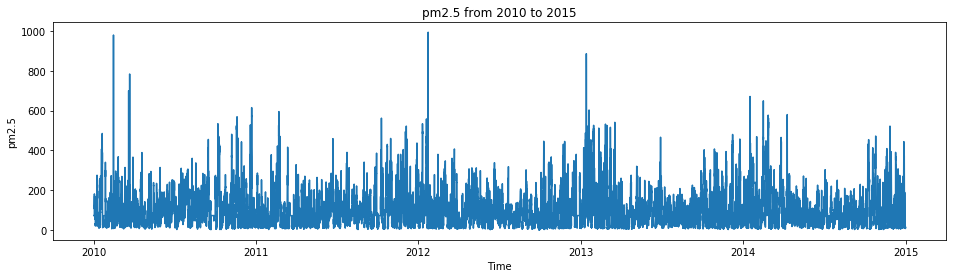

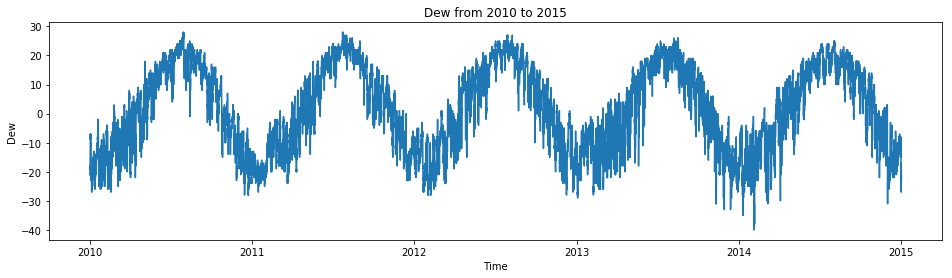

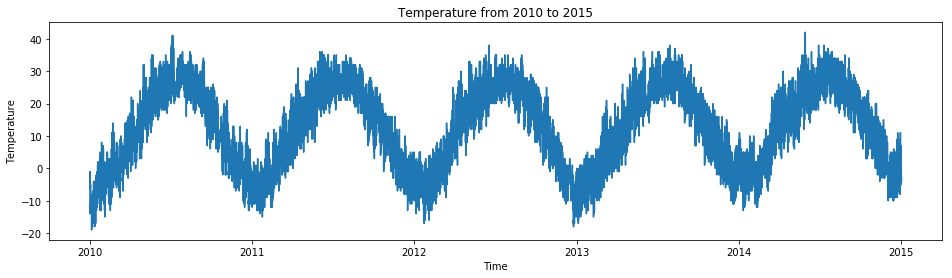

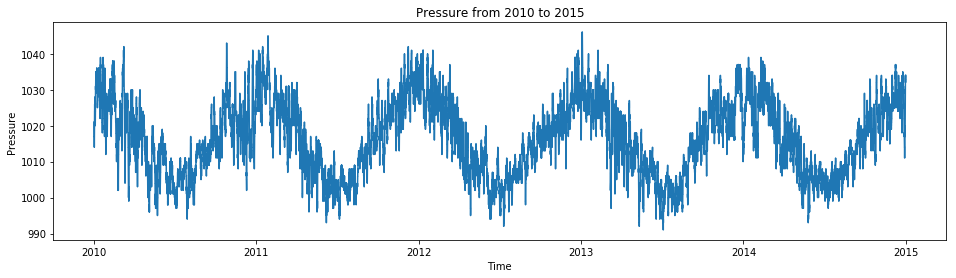

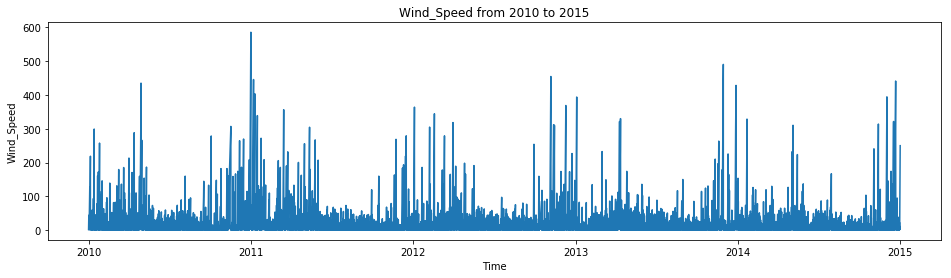

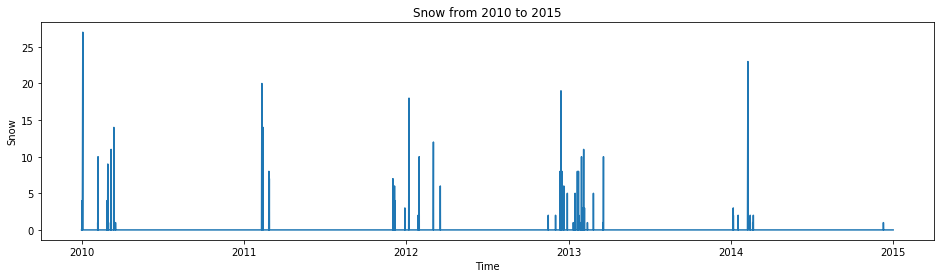

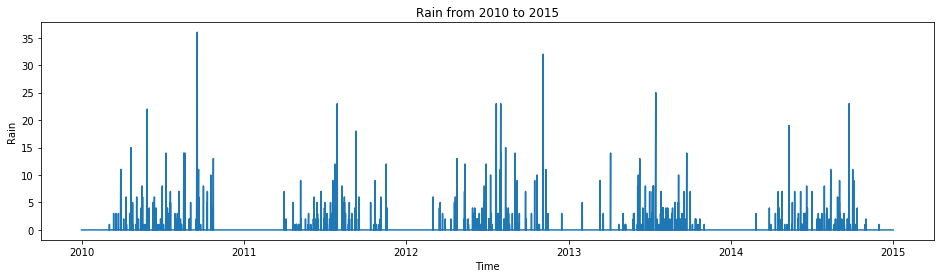

In [16]:
#plot the change of pm2.5 over the five-year period
plt.figure(figsize=(16, 4))#set figure size
g = sns.lineplot(y=data['pm2.5'],x=data['datetime'])#plot line chart
g.set_title('pm2.5 from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('pm2.5')
#plot the change of Dew over the five-year period
plt.figure(figsize=(16, 4))
g = sns.lineplot(y=data['Dew'],x=data['datetime'])
g.set_title('Dew from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('Dew')
#plot the change of Temperature over the five-year period
plt.figure(figsize=(16, 4))
g = sns.lineplot(y=data['Temperature'],x=data['datetime'])
g.set_title('Temperature from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('Temperature')
#plot the change of Pressure over the five-year period
plt.figure(figsize=(16, 4))
g = sns.lineplot(y=data['Pressure'],x=data['datetime'])
g.set_title('Pressure from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('Pressure')
#plot the change of Wind_Speed over the five-year period
plt.figure(figsize=(16, 4))
g = sns.lineplot(y=data['Wind_Speed'],x=data['datetime'])
g.set_title('Wind_Speed from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('Wind_Speed')
#plot the change of Snow over the five-year period
plt.figure(figsize=(16, 4))
g = sns.lineplot(y=data['Snow'],x=data['datetime'])
g.set_title('Snow from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('Snow')
#plot the change of Rain over the five-year period
plt.figure(figsize=(16, 4))
g = sns.lineplot(y=data['Rain'],x=data['datetime'])
g.set_title('Rain from 2010 to 2015')
g.set_xlabel('Time')
g.set_ylabel('Rain')



The previous figure shows the change of each attribute over five years. Through the maps,
we can find that the range of each attribute is various.Thus,we need to scale them. In addition, Wind_Direction is nominal atrribute, we need to change it to numerical.

b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# write your code here
#chaneg Wind_Direction to numerical.
data['Wind_Direction']=LabelEncoder().fit_transform(data['Wind_Direction'])
#set the split point, 00:00,1,1,2014
testdata=datetime.datetime(year=2014,month=1,day=1,hour=0)
#split train date and test date
traindata=data.loc[data['datetime']<testdata]
testdata=data.loc[data['datetime']>=testdata]
#drop the datatime columns, it is useless now
traindata=traindata.drop(columns="datetime")
testdata=testdata.drop(columns="datetime")

#scale all data into (-1,1)
scaler=MinMaxScaler(feature_range=(0,1))
normalised_train=scaler.fit_transform(traindata)
normalised_test=scaler.fit_transform(testdata)
#generate supervised learning problem data
def transformdata(data,column_names, time_pre=1, time_fut=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    data_raw = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(time_pre, 0, -1):
        cols.append(data_raw.shift(i))
        names += [('%s(t-%d)' % (column_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, time_fut):
        cols.append(data_raw.shift(-i))
        if i == 0:
            names += [('%s(t)' % (column_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (column_names[j], i)) for j in range(n_vars)]
    # put it all together
    alldata = pd.concat(cols, axis=1)
    alldata.columns = names
    # drop rows with NaN values
    if dropnan:
        alldata.dropna(inplace=True)
    return alldata


#chage the original train into framed data for rnn
framed_train = transformdata(normalised_train,data.columns.values.tolist(), 1, 1,)
framed_test = transformdata(normalised_test,data.columns.values.tolist(), 1, 1,)
framed_train.drop(framed_train.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
framed_test.drop(framed_test.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#show some examples of framed data
print(framed_train.head(),framed_test.head())



   pm2.5(t-1)  Dew(t-1)  Temperature(t-1)  Pressure(t-1)  Wind_Direction(t-1)  \
1    0.072435  0.196721          0.133333       0.545455                  0.5   
2    0.072435  0.196721          0.116667       0.527273                  0.5   
3    0.072435  0.196721          0.133333       0.509091                  0.5   
4    0.072435  0.196721          0.083333       0.509091                  0.5   
5    0.072435  0.213115          0.116667       0.490909                  0.5   

   Wind_Speed(t-1)  Snow(t-1)  Rain(t-1)  pm2.5(t)  
1         0.002290        0.0        0.0  0.072435  
2         0.007639        0.0        0.0  0.072435  
3         0.010698        0.0        0.0  0.072435  
4         0.016047        0.0        0.0  0.072435  
5         0.021396        0.0        0.0  0.072435      pm2.5(t-1)  Dew(t-1)  Temperature(t-1)  Pressure(t-1)  Wind_Direction(t-1)  \
1    0.032885  0.307692          0.363636       0.456522                  0.5   
2    0.076233  0.307692          

/Users/zhengbaihui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/zhengbaihui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


By using datatime, we can easily split the first 4 years' data as the training set and the remaining 1 year's data as the test set. After that,we normalised the training set and the test set respectively. Then, because we want to use RNN to train a model, we need to generate framed data. In this part, we generate t-1 for each attributes and generate t+1 for PM2.5. This is because PM2.5 is the target.

c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

Train on 31556 samples, validate on 3507 samples
Epoch 1/15
 - 4s - loss: 0.1864 - val_loss: 0.0723
Epoch 2/15
 - 2s - loss: 0.0557 - val_loss: 0.0390
Epoch 3/15
 - 2s - loss: 0.0513 - val_loss: 0.0427
Epoch 4/15
 - 2s - loss: 0.0499 - val_loss: 0.0422
Epoch 5/15
 - 2s - loss: 0.0494 - val_loss: 0.0338
Epoch 6/15
 - 2s - loss: 0.0493 - val_loss: 0.0350
Epoch 7/15
 - 2s - loss: 0.0491 - val_loss: 0.0421
Epoch 8/15
 - 2s - loss: 0.0491 - val_loss: 0.0337
Epoch 9/15
 - 2s - loss: 0.0489 - val_loss: 0.0347
Epoch 10/15
 - 2s - loss: 0.0488 - val_loss: 0.0287
Epoch 11/15
 - 2s - loss: 0.0489 - val_loss: 0.0259
Epoch 12/15
 - 2s - loss: 0.0488 - val_loss: 0.0291
Epoch 13/15
 - 2s - loss: 0.0488 - val_loss: 0.0276
Epoch 14/15
 - 2s - loss: 0.0487 - val_loss: 0.0317
Epoch 15/15
 - 2s - loss: 0.0488 - val_loss: 0.0202


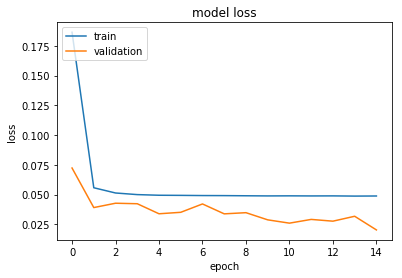

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout,BatchNormalization

# write your code here
#get the value of train data
npy_train=framed_train.values

#split validation set
validation_ratio=0.9
len_train=int(npy_train.shape[0]* validation_ratio)
len_val=npy_train.shape[0]-len_train


data_train=npy_train[:len_train,:-1].reshape((len_train,1,npy_train.shape[1]-1))
label_train=npy_train[:len_train,-1]
data_val=npy_train[len_train:,:-1].reshape((len_val,1,npy_train.shape[1]-1))
label_val=npy_train[len_train:,-1]

#define a simple RNN model with only one layer
model = Sequential()
model.add(LSTM(16, input_shape=(data_train.shape[1], data_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
#use MAE to measure loss and use adam as optimizer
model.compile(loss='mae', optimizer='adam')
# fit network and get the intermediate value
history = model.fit(data_train, label_train, epochs=15, batch_size=64, validation_data=(data_val, label_val), verbose=2, shuffle=False)
# plot loss during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()




In this part, we firstly set validation set for training model. Bacause of validation set, we can find whether the model has already overfited. The normal setting is 90% training set and 10% validation set. Then I  define a simple RNN model. This model only has a lstm layer. After lstm layer, I add a BatchNormalization layer. This layer can reduce the dependence on parameter initialization, increases the generalization ability of model and speed up training process. Dropout layer can avoid overfitting. Adam is a good optimizer.

Through the loss on train set and validation set, we can find this model does not overfit and converge quickly.It is a good model.

d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

RMSE on test set: 36.484


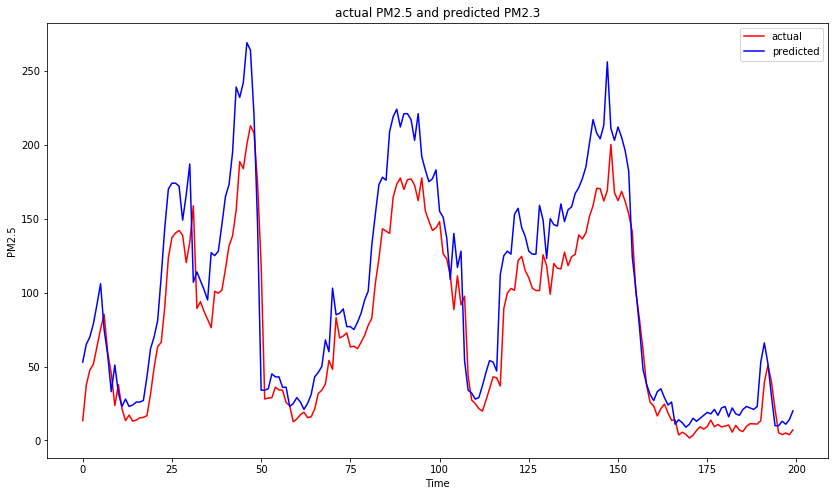

In [124]:
from sklearn.metrics import mean_squared_error
from numpy import concatenate
# write your code here
#get the test date and lebel
npy_test=framed_test.values
len_test=npy_test.shape[0]
data_test=npy_test[:,:-1].reshape((len_test,1,npy_test.shape[1]-1))
label_test=npy_test[:,-1]

# make a prediction
test_pred = model.predict(data_test)
data_test = data_test.squeeze()#reshape((data_test.shape[0], data_test.shape[2]))
#invert scaling for predicted data
inv_test_pred = concatenate((test_pred, data_test[:, 1:]), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]
# invert scaling for actual data
label_test = label_test.reshape((len(label_test), 1))
inv_label_test = concatenate((label_test, data_test[:, 1:]), axis=1)
inv_label_test = scaler.inverse_transform(inv_label_test)
inv_label_test = inv_label_test[:,0]
# calculate the RMSE
rmse = math.sqrt(mean_squared_error(inv_label_test, inv_test_pred))
print('RMSE on test set: %.3f' % rmse)

# Plot the predicted values vs. the actual values.
plt.figure(figsize=(14,8))
plt.plot(inv_test_pred[:200],color='r')
plt.plot(inv_label_test[:200],color='b')
plt.title('actual PM2.5 and predicted PM2.3')
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend(["actual","predicted"])

Becase when we trian the model, we scale all data into [-1,1], we need to invert the data to their original value when we calculate RSME and plot them. Also we should add the predicted data with traindata, then use scaler.inverse_transform. Through this way, we can get the correct values.

As the figure shown, the predicted value is always higher than actual value. Though the plot, we can visualise the error. In order to show the error clearly, we only show the first 200 values.

e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

Train on 31556 samples, validate on 3507 samples
Epoch 1/100
 - 14s - loss: 0.0513 - val_loss: 0.0293
Epoch 2/100
 - 5s - loss: 0.0450 - val_loss: 0.0327
Epoch 3/100
 - 5s - loss: 0.0436 - val_loss: 0.0329
Epoch 4/100
 - 5s - loss: 0.0429 - val_loss: 0.0306
Epoch 5/100
 - 5s - loss: 0.0422 - val_loss: 0.0328
Epoch 6/100
 - 5s - loss: 0.0416 - val_loss: 0.0355
Epoch 7/100
 - 5s - loss: 0.0415 - val_loss: 0.0331
Epoch 8/100
 - 5s - loss: 0.0411 - val_loss: 0.0341
Epoch 9/100
 - 6s - loss: 0.0408 - val_loss: 0.0334
Epoch 10/100
 - 6s - loss: 0.0405 - val_loss: 0.0341
Epoch 11/100
 - 6s - loss: 0.0404 - val_loss: 0.0340
Epoch 12/100
 - 6s - loss: 0.0401 - val_loss: 0.0319
Epoch 13/100
 - 6s - loss: 0.0399 - val_loss: 0.0345
Epoch 14/100
 - 6s - loss: 0.0395 - val_loss: 0.0341
Epoch 15/100
 - 6s - loss: 0.0392 - val_loss: 0.0333
Epoch 16/100
 - 6s - loss: 0.0387 - val_loss: 0.0356
Epoch 17/100
 - 6s - loss: 0.0382 - val_loss: 0.0334
Epoch 18/100
 - 6s - loss: 0.0372 - val_loss: 0.0343
Epoch

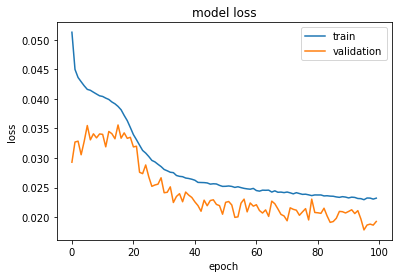

In [114]:
# write your code here
from keras.layers import BatchNormalization
#get the train data
npy_train=framed_train.values
#generate a new model
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(data_train.shape[1], data_train.shape[2]),return_sequences=True))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))
#add one more lstm layer
model_1.add(LSTM(32))
#model_1.add(Activation("tanh"))
model_1.add(Dropout(0.3))
model_1.add(Dense(1))
model_1.compile(loss='mae', optimizer='adam')
# fit network
history_1 = model_1.fit(data_train, label_train, epochs=100, batch_size=64, validation_data=(data_val, label_val), verbose=2, shuffle=False)
# plot history
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()




In this part, we can find that through add one lstm layer, the model achieved lower loss in both training set and validation set. I tried to add two or more lstm layers ,but the model is not good enough. Too complex model needs more time to trian. This model is simple and powerful.

Though the figure, we can find the validation loss and train loss have downward trends. And the loss of train set is reasonable, which means the model has not overfitted.

Train on 31556 samples, validate on 3507 samples
Epoch 1/100
 - 18s - loss: 0.0492 - val_loss: 0.0248
Epoch 2/100
 - 8s - loss: 0.0444 - val_loss: 0.0309
Epoch 3/100
 - 8s - loss: 0.0430 - val_loss: 0.0295
Epoch 4/100
 - 8s - loss: 0.0422 - val_loss: 0.0331
Epoch 5/100
 - 8s - loss: 0.0414 - val_loss: 0.0311
Epoch 6/100
 - 8s - loss: 0.0407 - val_loss: 0.0337
Epoch 7/100
 - 8s - loss: 0.0402 - val_loss: 0.0356
Epoch 8/100
 - 8s - loss: 0.0397 - val_loss: 0.0329
Epoch 9/100
 - 8s - loss: 0.0391 - val_loss: 0.0337
Epoch 10/100
 - 8s - loss: 0.0387 - val_loss: 0.0365
Epoch 11/100
 - 8s - loss: 0.0378 - val_loss: 0.0341
Epoch 12/100
 - 8s - loss: 0.0369 - val_loss: 0.0367
Epoch 13/100
 - 8s - loss: 0.0361 - val_loss: 0.0364
Epoch 14/100
 - 8s - loss: 0.0351 - val_loss: 0.0359
Epoch 15/100
 - 8s - loss: 0.0347 - val_loss: 0.0360
Epoch 16/100
 - 8s - loss: 0.0336 - val_loss: 0.0348
Epoch 17/100
 - 8s - loss: 0.0329 - val_loss: 0.0335
Epoch 18/100
 - 8s - loss: 0.0322 - val_loss: 0.0327
Epoch

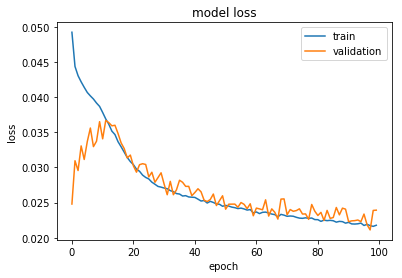

In [25]:
# write your code here
from keras.layers import BatchNormalization
#get the train data
npy_train=framed_train.values
#generate a new model
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(data_train.shape[1], data_train.shape[2]),return_sequences=True))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))
#add one more lstm layer# write your code here
from keras.layers import BatchNormalization
#get the train data
npy_train=framed_train.values
#generate a new model
model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(data_train.shape[1], data_train.shape[2]),return_sequences=True))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))
model_1.add(LSTM(32,return_sequences=True))
#model_1.add(Activation("tanh"))
model_1.add(Dropout(0.3))
model_1.add(LSTM(32,return_sequences=True))
#model_1.add(Activation("tanh"))
model_1.add(Dropout(0.3))
#add one more lstm layer
model_1.add(LSTM(64))
#model_1.add(Activation("tanh"))
model_1.add(Dropout(0.3))
model_1.add(Dense(1))
model_1.compile(loss='mae', optimizer='adam')
# fit network
history_1 = model_1.fit(data_train, label_train, epochs=100, batch_size=64, validation_data=(data_val, label_val), verbose=2, shuffle=False)
# plot history
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


It is the other model, I trained this model is deeper than previous one.
I'm sure if i train 200 epochs, it will achieve lower loss but i only train 100 epochs now.

Though the figure, we can find the validation loss and train loss have downward trends. And the loss of train set is reasonable, which means the model has not overfitted.

RMSE on test set: 34.226


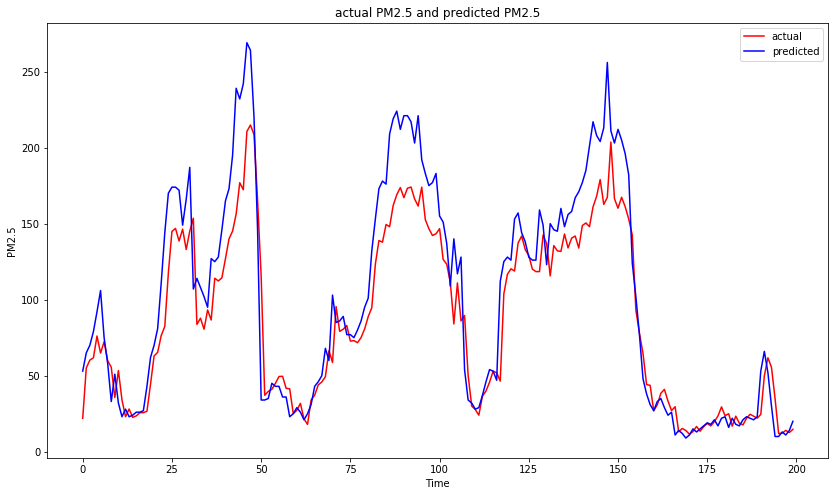

In [115]:
npy_test=framed_test.values
len_test=npy_test.shape[0]
data_test=npy_test[:,:-1].reshape((len_test,1,npy_test.shape[1]-1))
label_test=npy_test[:,-1]

# make a prediction
test_pred_1 = model_1.predict(data_test)
data_test = data_test.squeeze()#reshape((data_test.shape[0], data_test.shape[2]))
#invert scaling for predicted values
inv_test_pred_1 = concatenate((test_pred_1, data_test[:, 1:]), axis=1)
inv_test_pred_1 = scaler.inverse_transform(inv_test_pred_1)
inv_test_pred_1 = inv_test_pred_1[:,0]
# invert scaling for actual value
label_test = label_test.reshape((len(label_test), 1))
inv_label_test = concatenate((label_test, data_test[:, 1:]), axis=1)
inv_label_test = scaler.inverse_transform(inv_label_test)
inv_label_test = inv_label_test[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_label_test, inv_test_pred_1))
print('RMSE on test set: %.3f' % rmse)
# Plot the predicted values vs. the actual values.
plt.figure(figsize=(14,8))
plt.plot(inv_test_pred_1[:200],color='r')
plt.plot(inv_label_test[:200],color='b')
plt.title('actual PM2.5 and predicted PM2.5')
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend(["actual","predicted"])

The RMSE in new model is lower than old model. This means we get a better model. Through the map we can also find the predicted values are much closer to real valuse.

f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

(31492, 576) 31492 (31492,)
(31492, 72, 8) (31492,) (3500, 72, 8) (3500,)
Train on 31492 samples, validate on 3500 samples
Epoch 1/15
 - 74s - loss: 0.0360 - val_loss: 0.0244
Epoch 2/15
 - 69s - loss: 0.0198 - val_loss: 0.0166
Epoch 3/15
 - 67s - loss: 0.0158 - val_loss: 0.0142
Epoch 4/15
 - 66s - loss: 0.0143 - val_loss: 0.0134
Epoch 5/15
 - 67s - loss: 0.0139 - val_loss: 0.0130
Epoch 6/15
 - 66s - loss: 0.0136 - val_loss: 0.0130
Epoch 7/15
 - 67s - loss: 0.0135 - val_loss: 0.0129
Epoch 8/15
 - 67s - loss: 0.0134 - val_loss: 0.0126
Epoch 9/15
 - 68s - loss: 0.0134 - val_loss: 0.0125
Epoch 10/15
 - 69s - loss: 0.0133 - val_loss: 0.0129
Epoch 11/15
 - 68s - loss: 0.0133 - val_loss: 0.0126
Epoch 12/15
 - 68s - loss: 0.0132 - val_loss: 0.0126
Epoch 13/15
 - 66s - loss: 0.0132 - val_loss: 0.0128
Epoch 14/15
 - 69s - loss: 0.0132 - val_loss: 0.0128
Epoch 15/15
 - 65s - loss: 0.0132 - val_loss: 0.0122


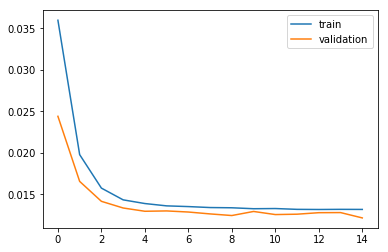

In [117]:

#generate 72 hours data
framed_train_3 = transformdata(normalised_train,data.columns.values.tolist(), 72, 1,)
framed_test_3 = transformdata(normalised_test,data.columns.values.tolist(), 72, 1,)
#set the split point
len_train_3=int(len(framed_train_3)*0.9)
len_val_3=framed_train_3.shape[0]-len_train_3

# split into train and test sets
train_2 = framed_train_3.values
test_2=framed_test_3.values

# split into train and validation set
data_train_2, label_train_2 = train_2[:len_train_3, :72*8], train_2[:len_train_3, -8]
data_val_2, label_val_2 = train_2[len_train_3:, :72*8], train_2[len_train_3:, -8]

#set the predicted values
data_test_2, label_test_2 = test_2[:, :72*8], test_2[:, -8]
print(data_train_2.shape, len(data_train_2), label_train_2.shape)

# reshape input to be 3D [samples, timesteps, features]
data_train_2 = data_train_2.reshape((data_train_2.shape[0], 72, 8))
data_val_2 = data_val_2.reshape((data_val_2.shape[0], 72, 8))
print(data_train_2.shape, label_train_2.shape, data_val_2.shape, label_val_2.shape)
 
# design a simple network considering training time
model_3 = Sequential()
model_3.add(LSTM(32, input_shape=(data_train_2.shape[1], data_train_2.shape[2])))
model_3.add(Dense(1))
model_3.compile(loss='mae', optimizer='adam')
# train network
history_3 = model_3.fit(data_train_2, label_train_2, epochs=15, batch_size=64, validation_data=(data_val_2, label_val_2), verbose=2, shuffle=False)
# plot loss
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='validation')
plt.legend()
plt.show()
 

In this part, we want to use 72 hours data to predict next hour. It means we should generate t-72 to t-1 hours data and t+1 data. After obtaining the data, I used a simple Lstm network to train the model. I only used one layer and 15 epochs. Becasue each epoch need a long time to trian. Fortunately, we can find the model has already converged within 15 epochs.

Test RMSE: 22.671


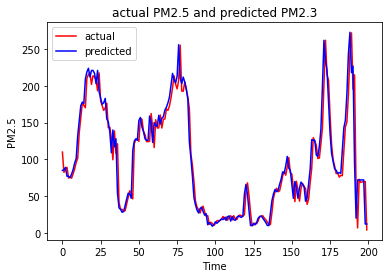

In [118]:
## make a prediction
data_test_2 = data_test_2.reshape((data_test_2.shape[0], 72, 8))
test_pred_3 = model_3.predict(data_test_2)
data_test_2 = data_test_2.reshape((data_test_2.shape[0], 72*8))
# invert scaling for forecast
inv_test_pred_3 = concatenate((test_pred_3, data_test_2[:, -7:]), axis=1)
inv_test_pred_3 = scaler.inverse_transform(inv_test_pred_3)
inv_test_pred_3 = inv_test_pred_3[:,0]
# invert scaling for actual
label_test_2 = label_test_2.reshape((len(label_test_2), 1))
inv_test_actual_3 = concatenate((label_test_2, data_test_2[:, -7:]), axis=1)
inv_test_actual_3 = scaler.inverse_transform(inv_test_actual_3)
inv_test_actual_3 = inv_test_actual_3[:,0]
# calculate RMSE
rmse_3 = math.sqrt(mean_squared_error(inv_test_actual_3, inv_test_pred_3))
print('Test RMSE: %.3f' % rmse_3)
plt.plot(inv_test_pred_3[:200],color='r')
plt.plot(inv_test_actual_3[:200],color='b')
plt.title('actual PM2.5 and predicted PM2.3')
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend(["actual","predicted"])

The figure and RMSE shows although i only use a very simple model, is still achieves best performance. This result tell us that using more data can also improve performance significantly. 